In [184]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold

# Available models
from sklearn.linear_model import (
    SGDRegressor,
    SGDClassifier,
    LogisticRegression,
    LinearRegression,
)
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

pd.set_option('display.max_rows', 100) # Set maximum displayed rows
pd.set_option('display.max_columns', 100) # Set maximum displayed columns
pd.set_option('display.max_colwidth', None)

In [150]:
from ipywidgets import interact, IntSlider, FloatSlider
import numpy as np
import pandas as pd
import matplotlib as mpl

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score

def sigmoid(x):
    return 1/(1+np.exp(-x))

def calculate_proba(x, threshold):
    data = np.linspace(-5, 5, num=11)
    true_class = [0,0,1, 0, 0, 1, 0, 1, 0, 1, 1]
    proba = sigmoid(data)
    predictions = [1 if p  >= threshold else 0 for p in proba]
    
    return (data, true_class, proba, predictions)

def calculate_matrix(predictions, true_class):
    cf_data = list(zip(predictions, true_class))
    tp = sum([1 if d==(1, 1) else 0 for d in cf_data])
    tn = sum([1 if d==(0, 0) else 0 for d in cf_data])
    fp = sum([1 if d==(1, 0) else 0 for d in cf_data])
    fn = sum([1 if d==(0, 1) else 0 for d in cf_data])
    
    #array = [[tp,fp],[tn,fn]]
    array = [[1,2],[3,4]]
    
    df_cm = pd.DataFrame(array, index = ['Negative', 'Positive'],
                  columns = ['Negative', 'Positive'])
    
    annotations = pd.DataFrame([[f'TN\n{tn}',f'FP\n{fp}'],[f'FN\n{fn}',f'TP\n{tp}' ]])
    return df_cm, annotations

def calculate_metrics(predictions, true_class):
    precision = precision_score(true_class, predictions,zero_division=0)
    recall = recall_score(true_class, predictions)
    f1 = f1_score(true_class, predictions)
    accuracy = accuracy_score(true_class, predictions)
    return  precision, recall, accuracy, f1

def update_original(threshold = 0.5):
    data, true_class, proba, predictions = calculate_proba(x, threshold)
    df_cm = calculate_matrix(predictions, true_class)
    
    axes[0][1].clear()
    axes[1][0].clear()
    sns.heatmap(df_cm, annot=True, ax=axes[0][1],cbar=False, cmap='Purples')
    threshold_line.set_ydata()
    metrics = calculate_metrics(predictions, true_class)
    
    axes[1][0].barh(['Precision','Recall'],metrics)
    
    fig.canvas.draw_idle()
  
def create_plot(threshold = 0.5):
    
    fig, axes = plt.subplots(2,2, figsize=(10, 10))
    draw_plot(axes, threshold)
    
    return fig, axes

def separate_classes(data, true_class, predictions, proba):
    all_data = zip(data, true_class, predictions, proba)
    
    tp = []
    tn = []
    fp = []
    fn = []
    
    for d in all_data:
        if d[1] == d[2] and d[1] == 0:
            tn.append(d) 
        if d[1] == d[2] and d[1] == 1:
            tp.append(d) 
        if d[1] != d[2] and d[1] == 1:
            fn.append(d) 
        if d[1] != d[2] and d[1] == 0:
            fp.append(d) 
    
    return {'tp':tp, 'tn':tn, 'fp':fp, 'fn':fn}

def draw_plot(axes, threshold):
    x = np.linspace(-6, 6)
    data, true_class, proba, predictions = calculate_proba(x, threshold)
    label_font = {'size':'12', 'weight':'bold'}
    
    classes = separate_classes(data, true_class, predictions, proba)
    
    axes[0][0].axhspan(-.18, threshold, facecolor='dimgrey', alpha=0.2)
    axes[0][0].axhspan(threshold, 1.18, facecolor='powderblue', alpha=0.2)
    
    sigmoid_curve, = axes[0][0].plot(x, sigmoid(x))
    threshold_line, = axes[0][0].plot(x, np.ones(len(x))*threshold, c='r', linestyle='--')
    axes[0][0].set_xlim(-6,6)
    axes[0][0].set_ylim(-.18,1.18)
    axes[0][0].set_xlabel("Feature Space", fontdict=label_font)
    axes[0][0].set_ylabel("Probability", fontdict=label_font)
    
    axes[0][0].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    
    #axes[0][0] = axes[0][0].scatter(data, sigmoid(data), marker = symbols, s=400, c=true_class)
    
    colors = {'tp':'darkorchid', 'tn':'mediumpurple', 'fp':'lightcoral', 'fn':'lightsalmon'}
    
    for k, v in classes.items():
        if k == 'tp' or k == 'fn':
            m = 's'
            s = 300
        else:
            m = 'o'
            s = 400
        c = colors.get(k)
        
        values = np.array([d[0] for d in v])
        
        axes[0][0].scatter(values,sigmoid(values), marker=m,s=s, color=c)
    
    precision, recall, accuracy, f1 = calculate_metrics(predictions, true_class)
        
    axes[1][0].barh(['Precision','Recall'],[precision, recall], color=['darkgreen','coral'])
    axes[1][1].barh(['Accuracy','F1-Score'],[accuracy, f1], color=['mediumturquoise','plum'])
    axes[1][1].yaxis.set_label_position("right")
    axes[1][1].yaxis.tick_right()
    
    axes[1][1].annotate(  f'{f1:.02}', (f1/2, 1), size=12, weight='bold', color='white')
    axes[1][1].annotate(f'{accuracy:.01%}', (accuracy/2, 0),size=12, weight='bold', color='white')
    axes[1][0].annotate(  f'{precision:.01%}', (precision/2, 0), size=12, weight='bold', color='white')
    axes[1][0].annotate(f'{recall:.01%}', (recall/2, 1),size=12, weight='bold', color='white')
    
    axes[1][0].set_xlim(0,1)
    axes[1][1].set_xlim(0,1)
    df_cm, annotations = calculate_matrix(predictions, true_class)
    
    #create a discrete color mapping
    colors = ['darkorchid', 'lightcoral','lightsalmon','mediumpurple']
    levels = [0,1,2,3,4]
    cmap, norm = mpl.colors.from_levels_and_colors(levels=levels, colors=colors)

    cfm = sns.heatmap(df_cm,square=True, annot=annotations,fmt='', 
                      ax=axes[0][1],cbar=False, linewidth=.5, linecolor='k',
                      annot_kws={"size": 14,'weight':'bold'}, cmap=cmap)
    
    axes[0][1].set_xlabel('Predicted labels', fontdict=label_font);
    axes[0][1].set_ylabel('Actual labels', fontdict=label_font);
    
    return None

def update_plot(threshold = 0.5):
    
    for ax in axes.flatten():
        ax.clear()
    
    draw_plot(axes, threshold)
    
    fig.canvas.draw_idle()

def draw_roc_plot(select, auc, compare, ax):
    #plt.close()
    fpr= np.array([0,.03,.06,.11,.2,.3,.5,1])
    tpr =np.array([0,.3,.55,.8,.9,.95,.98,1])
    ratio = tpr[1:]/fpr[1:]
    text_y_pos = [0,0.01,.2, .35, .4, .45, .6, .5]
    
    if auc or compare:
        pts = np.array(list(zip(fpr,tpr))+[[1,0]])
        p = Polygon(pts, closed=False, color='gold', alpha=.2)
        ax.add_patch(p)
        ax.annotate(  f'AUC = 0.79', (.4, 0.93), size=20, weight='bold', color='maroon');
    else:
        ax.plot(np.ones(5)*fpr[select], np.linspace(0,tpr[select],5), color='gold',alpha=.2, linestyle='-', linewidth=40);
        ax.annotate(  f'TPR/FPR: {ratio[select-1]:.01f}', (fpr[select]-.01,text_y_pos[select]), size=16,rotation=90, weight='bold', color='maroon');
    
    if compare:
        fpr_b= np.array([0,.031,.09,.15,.23,.4,.6,1])
        tpr_b =np.array([0,.2,.5,.6,.71,.85,.91,1])
        pts = np.array(list(zip(fpr_b,tpr_b))+[[1,0]])
        p = Polygon(pts, closed=False, color='darkgreen', alpha=.5)
        ax.add_patch(p)
        ax.annotate(  f'AUC = 0.68', (.4, 0.75), size=20, weight='bold', color='white');
        ax.plot(fpr_b, tpr_b, color='b');
        ax.scatter(fpr_b, tpr_b, color='b', s=180);
        
        
        
    ax.plot(fpr, tpr, color='k');
    ax.scatter(fpr, tpr, color='k', s=180);
    ax.plot(np.linspace(0,1,5), np.linspace(0,1,5), color='r', linestyle='--');
    label_font = {'size':'12', 'weight':'bold'}
    ax.set_xlabel('False Positive Rate\n(1-Specificity)',fontdict=label_font);
    ax.set_ylabel('True Positive Rate\n(Sensitivity/Recall)',fontdict=label_font);
    ax.set_xlim(0, 1.02);
    ax.set_ylim(0, 1.02);
    return None  

def update_roc_plot(select, auc, compare, ax):
    ax.clear()
    
    draw_roc_plot(select, auc, compare, ax)
    
    fig.canvas.draw_idle()

def create_roc_plot(select=1, auc=False, compare=False):
    
    fig, ax = plt.subplots(1,1,figsize=(8,8))
    draw_roc_plot(select=1, auc=False, compare=False,ax=ax)
    
    return fig, ax

def split_and_scale(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7, random_state=42)

    scaler = StandardScaler().fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    return X_train, X_test, y_train, y_test

def prep_regression():
    data = pd.read_csv('Lecture_data/fish.csv')
    # Prepare X and y
    X = data[['Length1', 'Length2', 'Length3', 'Height', 'Width']]
    y = data['Weight']

    return split_and_scale(X, y)

def prep_classification():
    data = pd.read_csv('Lecture_data/wines_binary.csv')
    
    X=data.drop(columns=['is_good_quality'])
    y=data.is_good_quality
    
    return split_and_scale(X, y)

In [151]:
df = pd.read_csv('ifood_dataset.csv').sort_index(axis=1)
df.head()

,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Complain,Dt_Customer,Education,ID,Income,Kidhome,Marital_Status,MntFishProducts,MntFruits,MntGoldProds,MntMeatProducts,MntSweetProducts,MntWines,NumCatalogPurchases,NumDealsPurchases,NumStorePurchases,NumWebPurchases,NumWebVisitsMonth,Recency,Response,Teenhome,Year_Birth,Z_CostContact,Z_Revenue
0,0,0,0,0,0,0,2012-09-04,Graduation,5524,58138.0,0,Single,172,88,88,546,88,635,10,3,4,8,7,58,1,0,1957,3,11
1,0,0,0,0,0,0,2014-03-08,Graduation,2174,46344.0,1,Single,2,1,6,6,1,11,1,2,2,1,5,38,0,1,1954,3,11
2,0,0,0,0,0,0,2013-08-21,Graduation,4141,71613.0,0,Together,111,49,42,127,21,426,2,1,10,8,4,26,0,0,1965,3,11
3,0,0,0,0,0,0,2014-02-10,Graduation,6182,26646.0,1,Together,10,4,5,20,3,11,0,2,4,2,6,26,0,0,1984,3,11
4,0,0,0,0,0,0,2014-01-19,PhD,5324,58293.0,1,Married,46,43,15,118,27,173,3,5,6,5,5,94,0,0,1981,3,11


In [152]:
df.describe()

,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Complain,ID,Income,Kidhome,MntFishProducts,MntFruits,MntGoldProds,MntMeatProducts,MntSweetProducts,MntWines,NumCatalogPurchases,NumDealsPurchases,NumStorePurchases,NumWebPurchases,NumWebVisitsMonth,Recency,Response,Teenhome,Year_Birth,Z_CostContact,Z_Revenue
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0
mean,0.064286,0.013393,0.072768,0.074554,0.072768,0.009375,5592.159821,52247.251354,0.444196,37.525446,26.302232,44.021875,166.950000,27.062946,303.935714,2.662054,2.325000,5.790179,4.084821,5.316518,49.109375,0.149107,0.506250,1968.805804,3.0,11.0
std,0.245316,0.114976,0.259813,0.262728,0.259813,0.096391,3246.662198,25173.076661,0.538398,54.628979,39.773434,52.167439,225.715373,41.280498,336.597393,2.923101,1.932238,3.250958,2.778714,2.426645,28.962453,0.356274,0.544538,11.984069,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1893.000000,3.0,11.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2828.250000,35303.000000,0.000000,3.000000,1.000000,9.000000,16.000000,1.000000,23.750000,0.000000,1.000000,3.000000,2.000000,3.000000,24.000000,0.000000,0.000000,1959.000000,3.0,11.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5458.500000,51381.500000,0.000000,12.000000,8.000000,24.000000,67.000000,8.000000,173.500000,2.000000,2.000000,5.000000,4.000000,6.000000,49.000000,0.000000,0.000000,1970.000000,3.0,11.0
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8427.750000,68522.000000,1.000000,50.000000,33.000000,56.000000,232.000000,33.000000,504.250000,4.000000,3.000000,8.000000,6.000000,7.000000,74.000000,0.000000,1.000000,1977.000000,3.0,11.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11191.000000,666666.000000,2.000000,259.000000,199.000000,362.000000,1725.000000,263.000000,1493.000000,28.000000,15.000000,13.000000,27.000000,20.000000,99.000000,1.000000,2.000000,1996.000000,3.0,11.0


In [153]:
df = df.drop(columns=["ID", "Z_CostContact", "Z_Revenue"])

In [154]:
df = df.dropna()

## Feature Engineering

In [155]:
today = pd.Timestamp(pd.to_datetime('2020-01-01', format='%Y-%m-%d'))
dt_column = pd.to_datetime(df.Dt_Customer, format='%Y-%m-%d')
df["Dt_Customer"] = dt_column
days_with_company = (today - df['Dt_Customer']).dt.days
df['Days_With_Company'] = days_with_company
df = df.drop(columns=["Dt_Customer"])

In [156]:
df["NumTotalPurchases"] = df["NumCatalogPurchases"] + df["NumStorePurchases"] + df["NumWebPurchases"]

In [157]:
df["NumAcceptedCmp"] = df["AcceptedCmp1"] + df["AcceptedCmp2"] + df["AcceptedCmp3"] + df["AcceptedCmp4"] + df["AcceptedCmp5"]

In [158]:
df["NumChildren"] = df['Kidhome'] + df['Teenhome']

In [159]:
current_year = 2014
df["CustomerAge"] = current_year - df["Year_Birth"]
df = df.drop(columns=["Year_Birth"])

In [160]:
df[df["Marital_Status"] == "Alone"]["Marital_Status"] = "Single"
df[df["Marital_Status"] == "Married"]["Marital_Status"] = "Together"
df = df[(df["Marital_Status"] == "Single") | (df["Marital_Status"] == "Together") | (df["Marital_Status"] == "Widow")]

/tmp/ipykernel_8697/3358864814.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df["Marital_Status"] == "Alone"]["Marital_Status"] = "Single"
/tmp/ipykernel_8697/3358864814.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df["Marital_Status"] == "Married"]["Marital_Status"] = "Together"


In [161]:
df = df[df["Income"] <= 200000] # drop outliers

In [162]:
df = df[df["CustomerAge"] <= 100]

In [163]:
product_columns = [
    "MntFishProducts",
    "MntMeatProducts",
    "MntFruits",
    "MntSweetProducts",
    "MntWines",
    "MntGoldProds"
]
df["MntTotal"] = df[product_columns].sum(axis=1)

In [205]:
random_state = 42

y = df["Response"]
X = df.drop(columns=[
    "Response", "AcceptedCmp1", "AcceptedCmp2",
    "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5",
    "Complain", "Education", "Marital_Status",
])
X = X.drop_duplicates()

y = y.loc[X.index]

print(X.shape)
print(y.shape)

smote = SMOTE(sampling_strategy='minority')
X, y = smote.fit_resample(X,y)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_index, test_index in split.split(X, y):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

(1012, 21)
(1012,)


In [206]:
numeric_data = X_train.select_dtypes(include=['int', 'float'])

In [207]:
numeric_data.columns

Index(['Income', 'Kidhome', 'MntFishProducts', 'MntFruits', 'MntGoldProds',
       'MntMeatProducts', 'MntSweetProducts', 'MntWines',
       'NumCatalogPurchases', 'NumDealsPurchases', 'NumStorePurchases',
       'NumWebPurchases', 'NumWebVisitsMonth', 'Recency', 'Teenhome',
       'Days_With_Company', 'NumTotalPurchases', 'NumAcceptedCmp',
       'NumChildren', 'CustomerAge', 'MntTotal'],
      dtype='object')

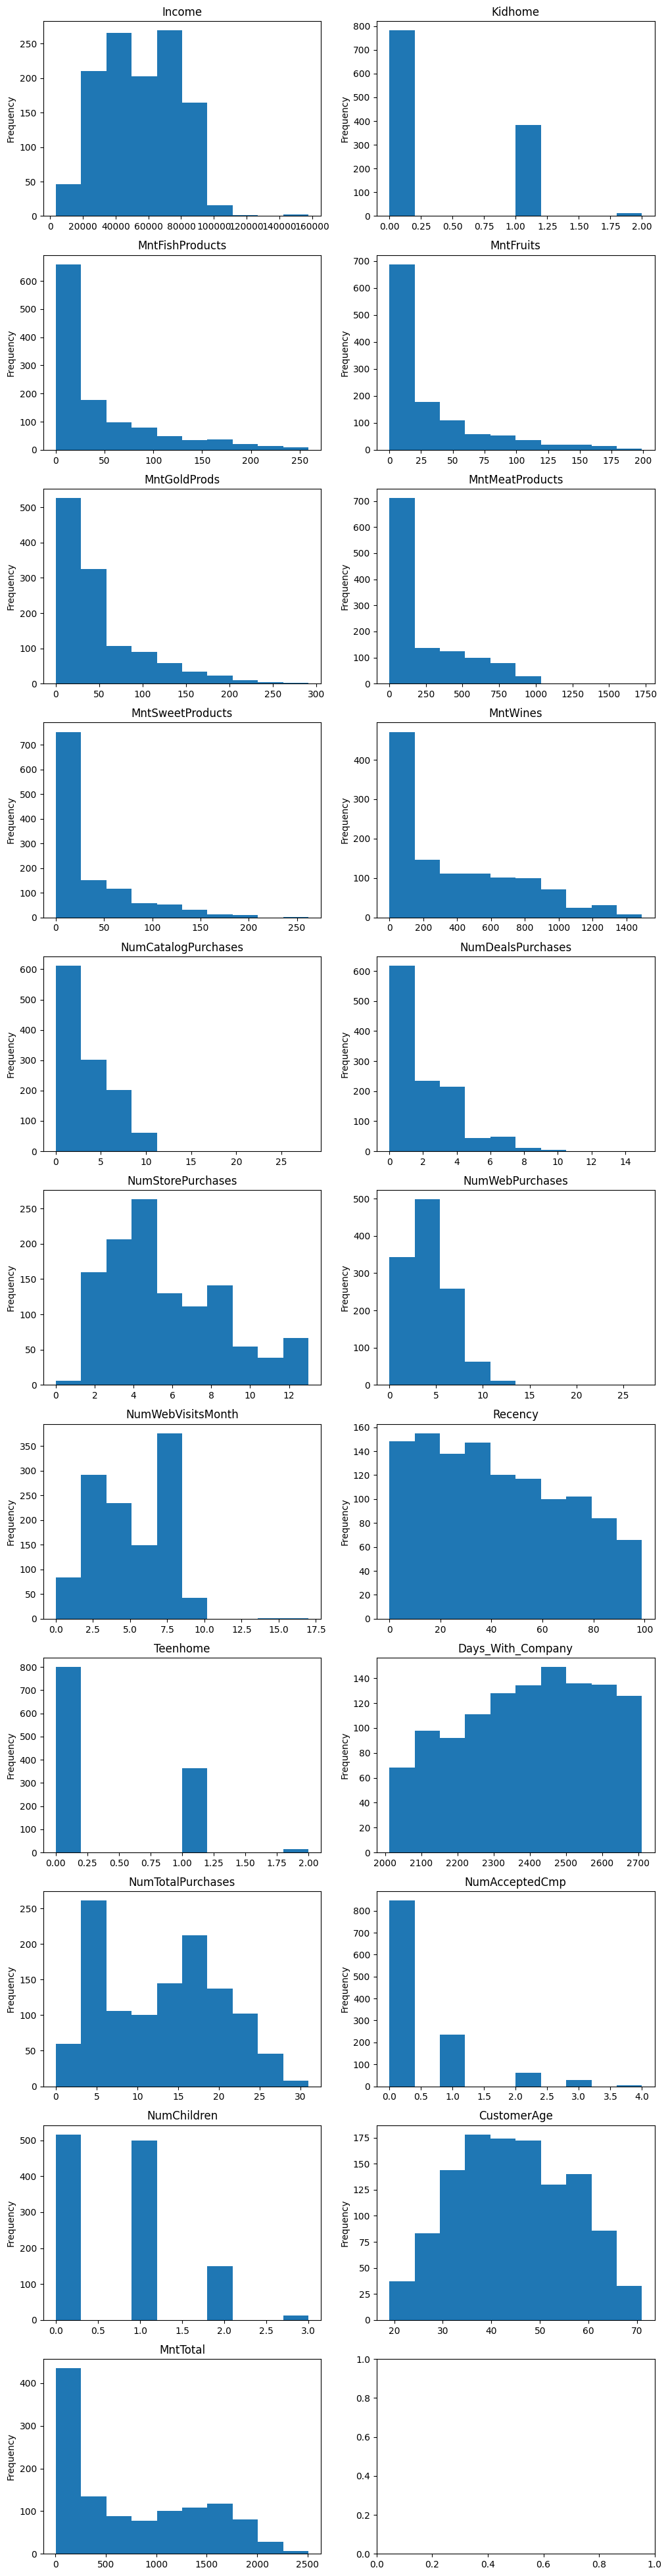

In [208]:
ncols = 2
nrows = int(np.ceil(len(numeric_data.columns) / ncols))
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12, 50))

for i, col in enumerate(numeric_data):
    idx_col, idx_row = i % ncols, i // ncols
    ax = axs[idx_row, idx_col]
    numeric_data[col].plot.hist(ax=ax)
    # ax.set_xlabel(col)
    ax.set_title(col)
plt.show()

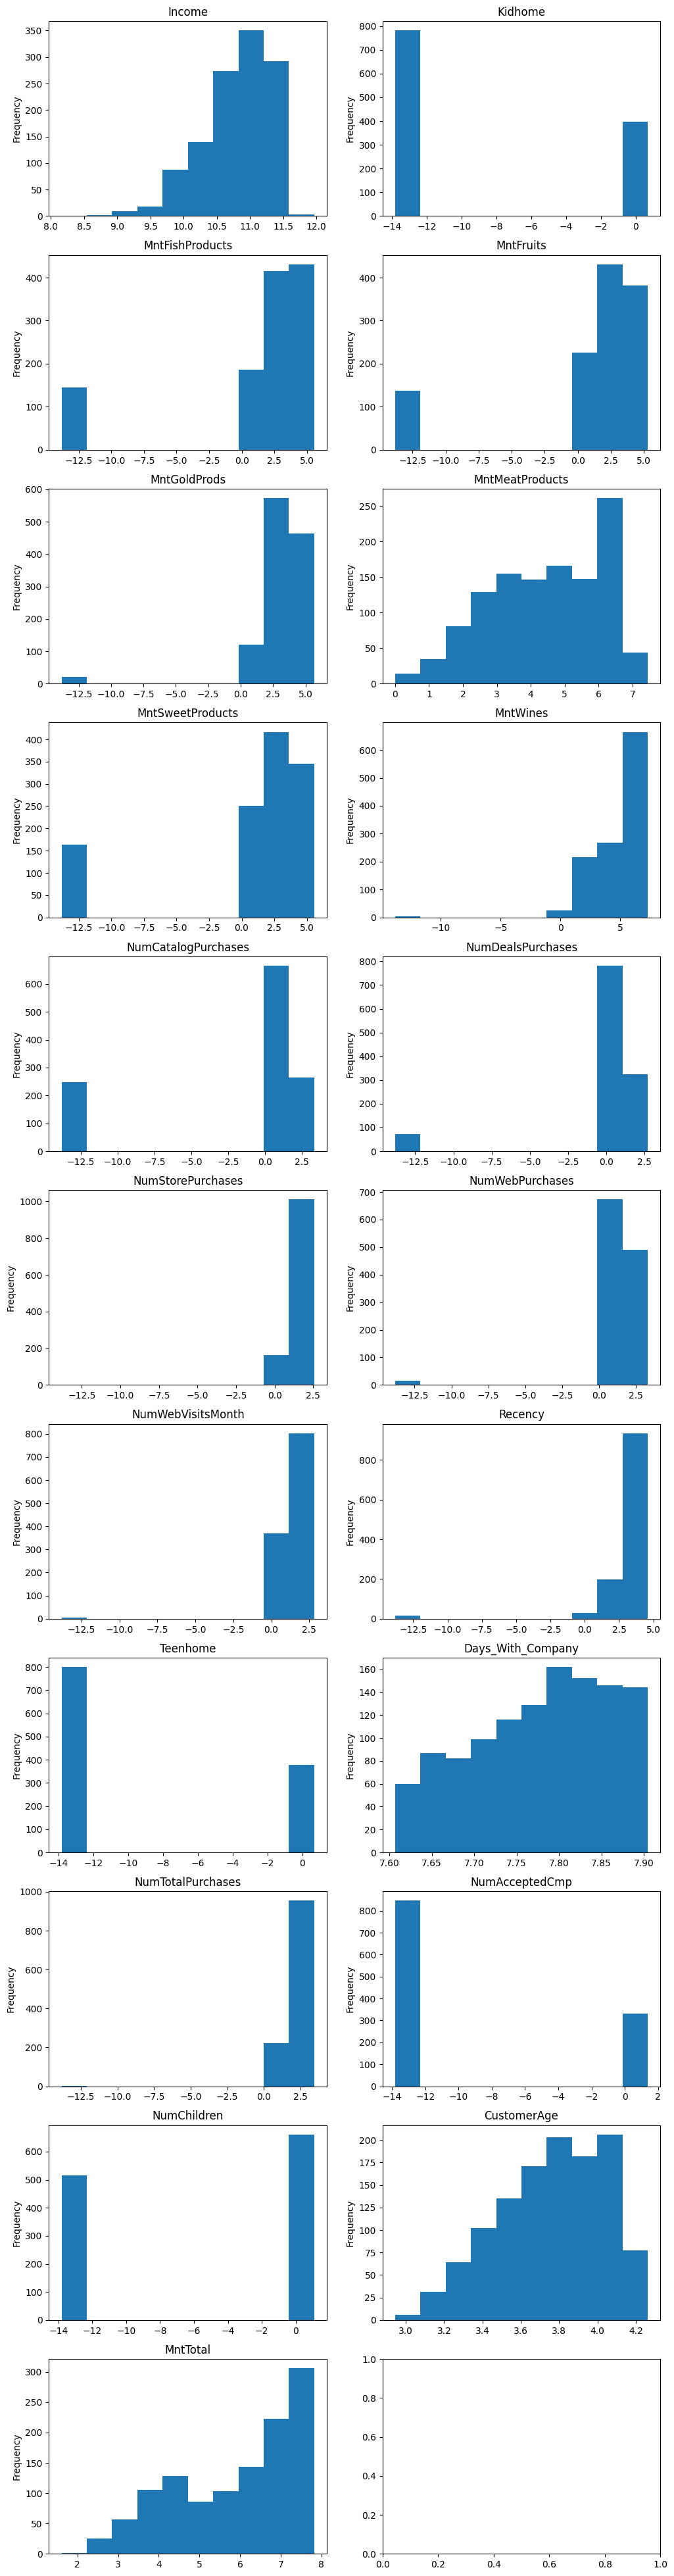

In [209]:
ncols = 2
nrows = int(np.ceil(len(numeric_data.columns) / ncols))
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12, 50))

for i, col in enumerate(numeric_data):
    idx_col, idx_row = i % ncols, i // ncols
    ax = axs[idx_row, idx_col]
    numeric_data[col].map(lambda x: np.log(x + 1e-6)).plot.hist(ax=ax)
    # ax.set_xlabel(col)
    ax.set_title(col)
plt.show()

In [210]:
df.columns

Index(['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4',
       'AcceptedCmp5', 'Complain', 'Education', 'Income', 'Kidhome',
       'Marital_Status', 'MntFishProducts', 'MntFruits', 'MntGoldProds',
       'MntMeatProducts', 'MntSweetProducts', 'MntWines',
       'NumCatalogPurchases', 'NumDealsPurchases', 'NumStorePurchases',
       'NumWebPurchases', 'NumWebVisitsMonth', 'Recency', 'Response',
       'Teenhome', 'Days_With_Company', 'NumTotalPurchases', 'NumAcceptedCmp',
       'NumChildren', 'CustomerAge', 'MntTotal'],
      dtype='object')

In [211]:
# Define data preprocessing transformers
min_max_numeric_transformer = make_pipeline(
    # Replace missing values with the mean
    SimpleImputer(strategy='mean'),
    # Scale numeric features
    MinMaxScaler()
)

standard_numeric_transformer = make_pipeline(
    # Replace missing values with the mean
    SimpleImputer(strategy='mean'),
    # Scale numeric features
    StandardScaler()
)

from sklearn.preprocessing import OrdinalEncoder

categorical_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),  # Replace missing values with the most frequent category
    OrdinalEncoder()  # One-hot encode categorical features
)

log_transformer = make_pipeline(
    FunctionTransformer(lambda x: np.log(x + 1e-6)),
    StandardScaler()
)

# Create a ColumnTransformer to apply different transformers to numeric and categorical columns
preprocessor = ColumnTransformer(
    [
        ('min_max_transformer', min_max_numeric_transformer, [
            "Recency", "Days_With_Company"
        ]),
        ('standard_transformer', standard_numeric_transformer, [
            "Income", "NumStorePurchases", "NumWebVisitsMonth",
            "NumTotalPurchases", "CustomerAge",
            "Kidhome", "Teenhome",
            "NumChildren",
            "MntFishProducts", "MntFruits", "MntGoldProds",
            "MntMeatProducts", "MntSweetProducts", "MntWines",
            "MntTotal", "NumCatalogPurchases", "NumDealsPurchases",
            "NumWebPurchases", "NumAcceptedCmp"
        ]),
    ]
)
preprocessor


ColumnTransformer(transformers=[('min_max_transformer',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['Recency', 'Days_With_Company']),
                                ('standard_transformer',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Income', 'NumStorePurchases',
                                  'NumWebVisitsMonth', 'NumTotalPurchases',
                                  'CustomerAge', 'Kidhome', 'Teenhome',
                                  'NumChildren', 'MntFishProducts', 'MntFruits',
                                  'MntGoldProds', 'MntMeatProducts',
                                  'MntSweetProducts', 'MntWines', 'MntTotal',
                                  'NumCatalogPurchases', 'NumDealsPurchases',
                                  'NumWebPurchases', 'NumAcceptedCmp'])])

In [212]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels=None, title='Confusion Matrix'):
    f1 = f1_score(y_true, y_pred, average='macro')
    fig, ax = plt.subplots(figsize=(6, 6))
    data = confusion_matrix(y_true, y_pred)

    total = data.sum()
    cfm_labels = []
    for row in data:
        total = row.sum()
        cfm_labels.append([f'{n}\n({n/total*100:1.1f}%)' for n in row])

    data = pd.DataFrame(data, columns=labels, index=labels)

    sns.heatmap(data, cmap='coolwarm',
                annot=cfm_labels,
                fmt='',
                square=True,
                cbar=False,
                ax=ax
                )

    ax.set_xlabel('Predicted Labels', size=14, weight='bold')
    ax.set_ylabel('True Labels', size=14, weight='bold')
    ax.set_title(f'{title}\n F1 Score: {f1:1.2f}', size=18)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

In [213]:
class MachineLearningEstimator:
    def __init__(self, random_state: int = 42,):
        self._x_train = None
        self._y_train = None
        self._best_model = None
        self._train_pipeline = None
        self._cross_val_score  = None
        self._random_state = random_state

    def setup_train(self, x_train=None, y_train=None, train_pipeline=None):
        # We need to invalidate any previous training
        self._best_model = None
        self._cross_val_score = None

        # Set the training data
        if x_train is not None:
            assert x_train.shape[1] > 1 and x_train.duplicated().sum() == 0, "There are duplicated rows in the dataset."
            self._x_train = x_train.copy()

        if y_train is not None:
            self._y_train = y_train.copy()

        if train_pipeline is not None:
            self._train_pipeline = train_pipeline

    def fit(self):
        self._train_pipeline.fit(self._x_train, self._y_train)
        self._best_model = self._train_pipeline

    def grid_search(self, **kwargs):
        grid_search = GridSearchCV(self._train_pipeline, **kwargs)
        self.fit()
        self._best_score = grid_search.best_score_
        self._best_model = grid_search.best_model_
        self._best_params = grid_search.best_params_

    def run_cross_val_score(self, **kwargs):
        self._cross_val_score = cross_val_score(X=self._x_train, y=self._y_train, estimator=self._train_pipeline, **kwargs)
        
        return np.mean(self._cross_val_score)

    def best_model(self):
        assert self._best_model is not None, "Fit the estimator first."
        return self._best_model

    def predict(self, data):
        assert self._best_model is not None, "Fit the estimator first."
        return self._best_model.predict(data)

    def predict_proba(self, data, threshold=0.5):
        assert self._best_model is not None
        y_pred = (self._best_model.predict_proba(data) >= threshold).astype(int)
        return y_pred

    def score(self, x, y) -> float:
        assert self._best_model is not None, "Fit the estimator first."
        return self._best_model.score(x, y)

    def score_metric(self, x, y, metric, threshold=0.5) -> float:
        assert self._best_model is not None, "Fit the estimator first."
        return metric(y, self.predict(x))

    def run_permutation_importance(self, x, y, n_repeats=30):
        assert self._best_model is not None, "Fit the estimator first."
        result = permutation_importance(
            self.best_model(),
            x,
            y,
            n_repeats=n_repeats,
            random_state=self._random_state
        )
        result_series = pd.Series(result.importances_mean)
        return result_series.sort_values(ascending=False)

In [214]:
def fit_data(model, X, y):
    # Build the complete model pipeline
    model_pipeline = Pipeline([
        ('preprocessor', preprocessor),  # Apply data preprocessing
        ('model', model)  # Train a Logistic Regression model
    ])

    estimator = MachineLearningEstimator()
    estimator.setup_train(X, y, train_pipeline=model_pipeline)
    estimator.fit()

    scores = {
        "precision": estimator.score_metric(X, y, precision_score),
        "recall": estimator.score_metric(X, y, recall_score),
        "accuracy": estimator.score_metric(X, y, accuracy_score),
        "f1": estimator.score_metric(X, y, f1_score)
    }
    plot_confusion_matrix(y_train, estimator.predict(X), title='Confusion Matrix', labels=["Rejected", "Accepted"])

    cv_results = cross_validate(estimator.best_model(), X_train, y_train, cv=5, 
        scoring=[
            "precision", "recall", "accuracy", "f1"
        ]
    )
    cv_results = pd.DataFrame(cv_results)

    return estimator, scores, cv_results

In [215]:
n_estimators = np.array([100])
max_depth = np.array([12])
criterion = np.array(["gini", ])
max_features = np.array(["sqrt", ])
min_samples_split = np.array([2,])
min_samples_leaf = np.array([1])

# Grid de hiperparâmetros
grid_parametros = dict(classifier__n_estimators = n_estimators,
                       classifier__max_depth = max_depth,
                       classifier__criterion = criterion,
                       classifier__max_features = max_features,
                       classifier__min_samples_split = min_samples_split,
                       classifier__min_samples_leaf = min_samples_leaf)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

randomForest = RandomForestClassifier()

model_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Apply data preprocessing
    ('classifier', randomForest)  # Train a Logistic Regression model
])

# Criando o modelo com o Grid de Hiperparametros
model_pipeline = GridSearchCV(model_pipeline, grid_parametros, cv=cv, n_jobs=8)

# Treinando os modelos
model_pipeline.fit(X_train, y_train)

# Obtendo e visualizando os parametros treinados
treinos_rf = pd.DataFrame(model_pipeline.cv_results_)

# Acurácia em Treino
print(f"Acurácia em Treinamento: {model_pipeline.best_score_ :.2%}")
print("")
print(f"Hiperparâmetros Ideais: {model_pipeline.best_params_}")
print("")
print("Numero de treinamentos realizados: ", treinos_rf.shape[0])

Acurácia em Treinamento: 89.27%

Hiperparâmetros Ideais: {'classifier__criterion': 'gini', 'classifier__max_depth': 12, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}

Numero de treinamentos realizados:  1


In [216]:
estimator = MachineLearningEstimator()
estimator.setup_train(X, y, train_pipeline=model_pipeline.best_estimator_)
estimator.fit()

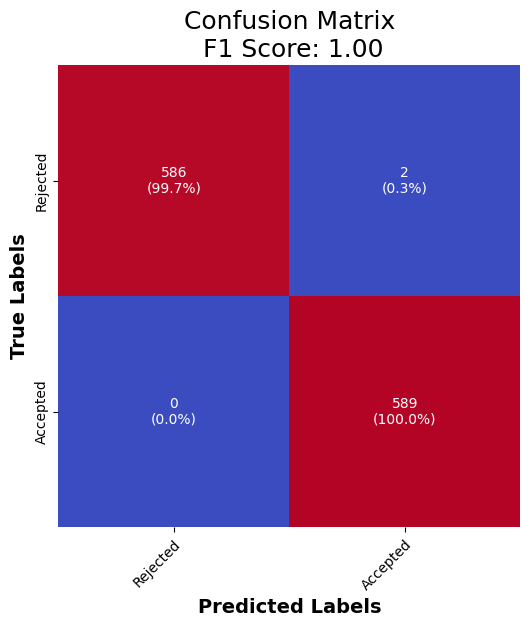

In [217]:
plot_confusion_matrix(y_train, estimator.predict(X_train), title='Confusion Matrix', labels=["Rejected", "Accepted"])

In [218]:
def custom_permutation_importance(model, x, y, n_repeats=30):
    result = permutation_importance(
        model,
        x,
        y,
        random_state=42,
        n_repeats=n_repeats
    )
    return result

In [219]:
result = custom_permutation_importance(estimator.best_model(), X_train, y_train)

result_series = pd.Series(result.importances_mean, X_train.columns).sort_values(ascending=False)
result_series

Recency                0.093996
Teenhome               0.039564
Days_With_Company      0.025772
NumWebVisitsMonth      0.016709
MntGoldProds           0.015491
NumStorePurchases      0.013537
NumDealsPurchases      0.010054
MntWines               0.008156
NumAcceptedCmp         0.007080
CustomerAge            0.006231
Income                 0.004673
MntMeatProducts        0.004050
MntTotal               0.003285
MntSweetProducts       0.002889
NumWebPurchases        0.002464
MntFishProducts        0.002152
NumChildren            0.001388
MntFruits              0.000850
Kidhome                0.000708
NumTotalPurchases      0.000510
NumCatalogPurchases    0.000453
dtype: float64

In [220]:
y_prob = estimator.best_model().predict_proba(X_train)
precision, recall, threshold = precision_recall_curve(y_train, y_prob[:,1])

In [221]:
prc_df = pd.DataFrame(precision,columns=['Precision'])
prc_df['Recall'] = recall
prc_df['Threshold'] = recall * 0
prc_df[prc_df['Precision'] > 0.95]

,Precision,Recall,Threshold
430,0.951535,1.000000,0.0
431,0.953074,1.000000,0.0
432,0.954619,1.000000,0.0
433,0.956169,1.000000,0.0
434,0.957724,1.000000,0.0
...,...,...,...
1031,1.000000,0.008489,0.0
1032,1.000000,0.006791,0.0
1033,1.000000,0.005093,0.0
1034,1.000000,0.003396,0.0


In [222]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Compute AUC score
auc_score = roc_auc_score(y_train, estimator.predict(X_train))
auc_score

0.9982993197278911

In [223]:
print(estimator.score_metric(X_test, y_test, precision_score))
print(estimator.score_metric(X_test, y_test, recall_score))
print(estimator.score_metric(X_test, y_test, accuracy_score))
print(estimator.score_metric(X_test, y_test, f1_score))

0.9960474308300395
1.0
0.998019801980198
0.998019801980198


0.9526315789473684
0.9836956521739131
0.9892569382273948
0.9679144385026737


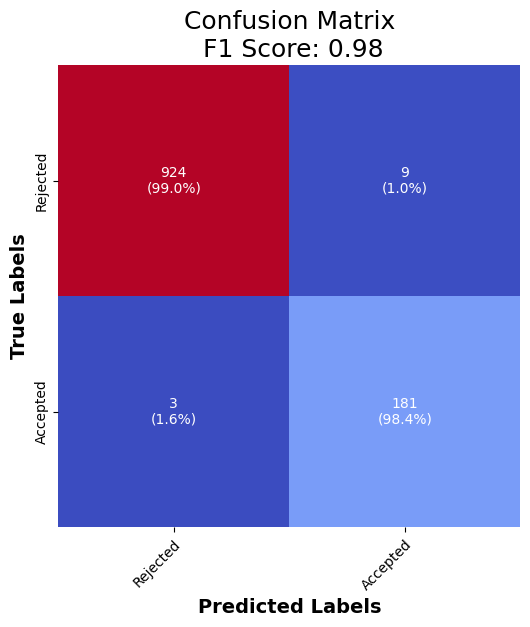

In [224]:
tmp_x = df.drop(columns=["Response",])
print(estimator.score_metric(tmp_x, df["Response"], precision_score))
print(estimator.score_metric(tmp_x, df["Response"], recall_score))
print(estimator.score_metric(tmp_x, df["Response"], accuracy_score))
print(estimator.score_metric(tmp_x, df["Response"], f1_score))
plot_confusion_matrix(df["Response"], estimator.predict(tmp_x), title='Confusion Matrix', labels=["Rejected", "Accepted"])